# Survivability of ICU Patients with Severe Sepsis Shock

Although U.S. hospitals pay out over $22.2 billion annually for sepsis treatment, the disease still causes 20-45 percent of death in hospitals. By the time the physical manifestations of sepsis start to appear, it’s sometimes too late to help the patient. Somewhere, buried in the data – in the blood values, the blood-pressure values, the heart rate, the temperature – is a prediction that this patient is heading toward an overwhelming infection and is likely to die. If we could predict that very early, it will make it less likely the patient would die.

A predictive model that determines which patients are most vulnerable can really help ICUs focus their Physicians and staff on the most vulnerable patients. Potentially, such selective treatment can reduce mortality without increasing spending. Through this Notebook, a machine learning model is being designed to predict death within 30 days of ICU admission for the patients who have been diagnosed with Sepsis/septic shock.

Detailed information on Solution Approach is available at - https://tinyurl.com/yckbcqxz

In [1]:
# Importing sqlalchemy to run SQL queries against MIMIC-III Postgres database
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, MetaData
import sqlalchemy

import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import datetime

import seaborn as sns
sns.set(style='ticks')
sns.set_context("notebook", font_scale=1)
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sqlalchemy.__version__

'1.0.11'

In [2]:
# Defining connection to Postgres database
# Set up SQL Alchemy engine and session

engine = create_engine("postgresql://********:********@*****************************************:5432/mimicdb")
m = MetaData(schema="mimiciii")


Base = automap_base(bind=engine, metadata=m)
Base.prepare(engine, reflect=True)

# For patient's admission, vitals and infection information, Classes are being created.
# Classes are mapped to the appropriate tables in Postgres.
Admission = Base.classes.admissions
Patient = Base.classes.patients
LabEvent = Base.classes.labevents
BioEvent = Base.classes.microbiologyevents

session = Session(engine)

#### Filter out all Admissions rows when patients were diagnosed with Sepsis

Admissions table is being queried to get admissions for all the patients who have been diagnosed with Sepsis.

In [3]:
admission_query = session.query(Admission).filter_by(diagnosis='SEPSIS')

df = pd.read_sql(admission_query.statement, admission_query.session.bind)

df.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
1,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,SINGLE,HISPANIC OR LATINO,2164-11-18 10:52:00,2164-11-18 21:31:00,SEPSIS,0,1
2,96,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,MARRIED,ASIAN,2176-02-25 10:35:00,2176-02-25 18:14:00,SEPSIS,0,1
3,20,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,JEWISH,MARRIED,WHITE,2135-01-30 18:46:00,2135-01-30 22:05:00,SEPSIS,1,1
4,448,353,108923,2151-03-28 16:01:00,2151-04-13 16:10:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PTUN,JEWISH,SINGLE,WHITE,2151-03-28 13:02:00,2151-03-28 17:46:00,SEPSIS,0,1


In [4]:
### Find out all the locations where patients got admitted 

df['admission_location'].unique()

array([u'EMERGENCY ROOM ADMIT', u'CLINIC REFERRAL/PREMATURE',
       u'TRANSFER FROM HOSP/EXTRAM', u'TRANSFER FROM SKILLED NUR',
       u'PHYS REFERRAL/NORMAL DELI', u'TRANSFER FROM OTHER HEALT'], dtype=object)

#### Find out if a Sepsis Diagnosed patient died within 30 days

For each of the admission, we will check if patient died within 30 days. If the patient dies within 30 days, we will flag that row. This flag will be used to determine outcome for Machine Learning models.

___Note: ___ We are not using hospital_expire_flag as that includes the patients who died past 30 days. We are only intrested in predicting whether patients died within 30 days of admission or not.

In [5]:
## Calculating if patient died within 30 days of admission
def period(row, period):
    
    if row['deathtime'] != row['deathtime']:
        return 0
    elif (row['deathtime'] - row['admittime']).days > period:
        return 0
    else:
        return 1

df['death_within_30_days'] = df.apply (lambda row: period (row, 30),axis=1)

In [6]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

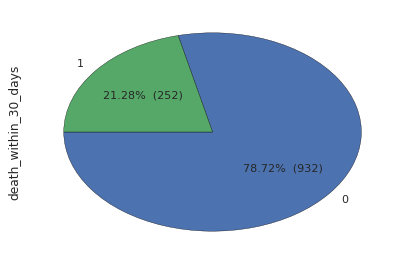

In [7]:
df.death_within_30_days.value_counts().plot.pie(autopct=make_autopct(df.death_within_30_days.value_counts()),startangle = 180)

___252 patients (i.e. 21.52%) of patients died withing 30 days.___

In [8]:
df.columns

Index([              u'row_id',           u'subject_id',
                    u'hadm_id',            u'admittime',
                  u'dischtime',            u'deathtime',
             u'admission_type',   u'admission_location',
         u'discharge_location',            u'insurance',
                   u'language',             u'religion',
             u'marital_status',            u'ethnicity',
                  u'edregtime',            u'edouttime',
                  u'diagnosis', u'hospital_expire_flag',
       u'has_chartevents_data', u'death_within_30_days'],
      dtype='object')

### Filtering out the columns that may impact the survivality. 

Keeping the time of admission as it will be needed later to calculate age at the time of admission. Dropping following columns (as they will have either no impact or minimal impact on survivalibility) -

1. dischtime
2. deathtime
3. admission_location
4. discharce_location
5. language - ethinicity is included if there is a variation based upon origin/race of the person.
6. religion - ethinicity is included if there is a variation based upon origin/race of the person.
7. marital_status
8. edregtime
9. edouttime
10. diagnosis (only sepsis customers are there in this DB)
11. hospital_expire_flag


Religion and Language may have impact, but it very unlikely. Ethinicy is more important, so keeping the ethnicity column.

In [9]:
admission_columns = ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'death_within_30_days']
admissions = df[admission_columns]
admissions.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_within_30_days
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0


## Get Patients demographics information

In [10]:
patient_query = session.query(Patient)
patients = pd.read_sql(patient_query.statement, patient_query.session.bind)
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13,NaT,NaT,NaT,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
2,236,251,M,2090-03-15,NaT,NaT,NaT,0
3,237,252,M,2078-03-06,NaT,NaT,NaT,0
4,238,253,F,2089-11-26,NaT,NaT,NaT,0


__Dropping the fields that has no impact on survivavility of Sepsis patients.__

In [11]:
patients = patients[['subject_id', 'gender', 'dob']]

__Joining patients and admission data into a single data frame__

In [12]:
patient_and_admission_data = admissions.join(patients.set_index('subject_id'), on='subject_id')
patient_and_admission_data.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_within_30_days,gender,dob
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23


#### Calculate the age of patient at the time of admission.

Using adminttime and dob, patient's age is calculated at the time of admission to hospital.

___Note: ___ Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. The shift process was as follows: the patient’s age at their first admission was determined. The date of birth was then set to exactly 300 years before their first admission. Since median age of such patient was 91.4, I am setting up age of such patient as 91


In [13]:
def calculate_age(row):
    age = int((row['admittime'] - row['dob']).days/365)   
    if age < 0:
        age = 91
    return age
patient_and_admission_data['age'] = patient_and_admission_data.apply(lambda row: calculate_age (row),axis=1)
patient_and_admission_data.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_within_30_days,gender,dob,age
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22,63
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22,52
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20,74
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,87
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,61


## Analyze patients basic data to understand the impact on survivavility

In [14]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


** Number and percentage of customers by age **

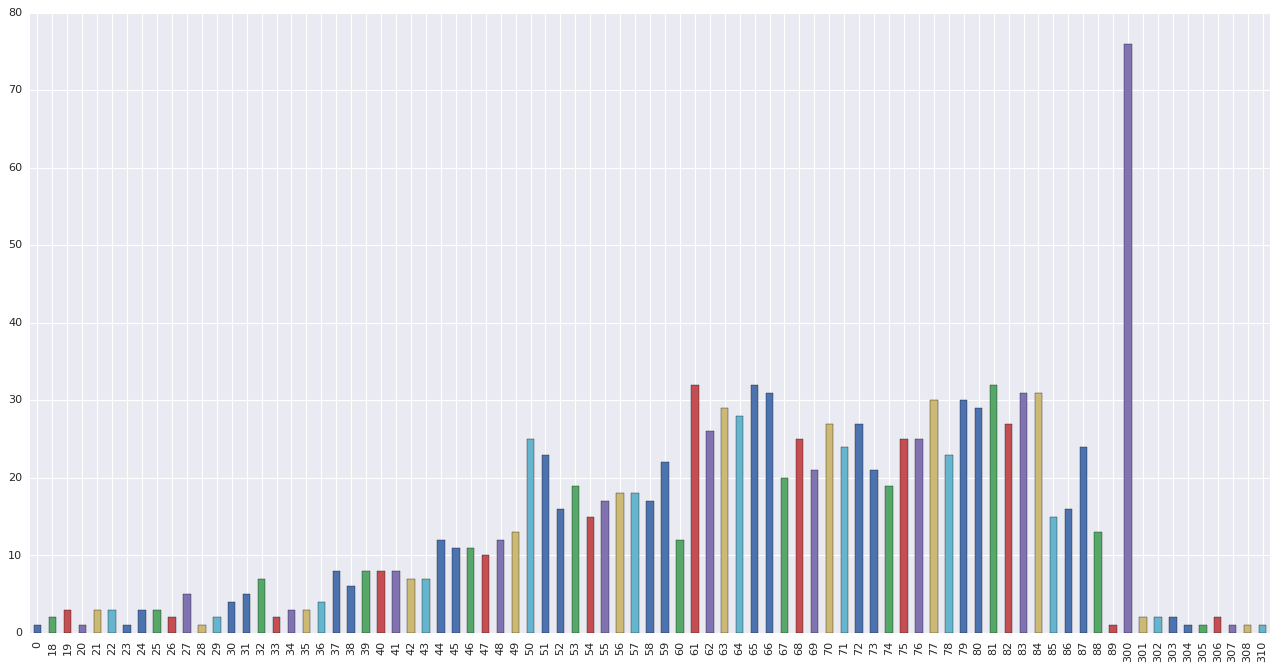

In [15]:
patient_and_admission_data.age.value_counts().sort_index().plot(kind='bar', figsize=(20, 10),stacked=True)

** Number of patients by age groups **

Patients have been broken into 5 categories - 0 to 20 years, 20 to 40 years, 40 to 60 years, 60 to 80 years and 80 to 100 years. Below chart shows number of patients by each age group in the dataset.

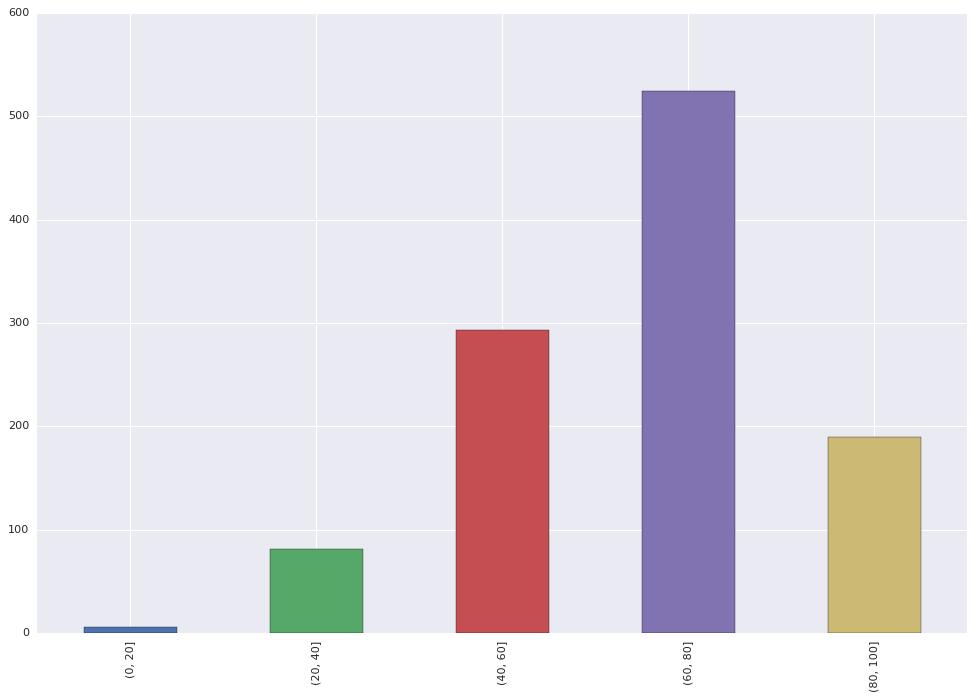

In [16]:
bins = [0, 20, 40, 60, 80, 100]
patient_and_admission_data['age_bins'] = pd.cut(patient_and_admission_data['age'], bins)
patient_and_admission_data.age_bins.value_counts().sort_index().plot(kind='bar', figsize=(15, 10),stacked=True)

** Survival or Death of customers by age group**

Since there are different number of customers in each age group, I will show the survival and death by both numbers and percentage such that we can truly compare the data.

___Note:___ 1 indicates the patient who died. 0 indicates the patients who survived.

In [17]:
death_within_30_days_by_agegroup = patient_and_admission_data.groupby(['age_bins','death_within_30_days'])['age_bins'].count()
death_within_30_days_by_agegroup

age_bins   death_within_30_days
(0, 20]    0                         6
(20, 40]   0                        72
           1                         9
(40, 60]   0                       241
           1                        52
(60, 80]   0                       413
           1                       111
(80, 100]  0                       140
           1                        50
Name: age_bins, dtype: int64

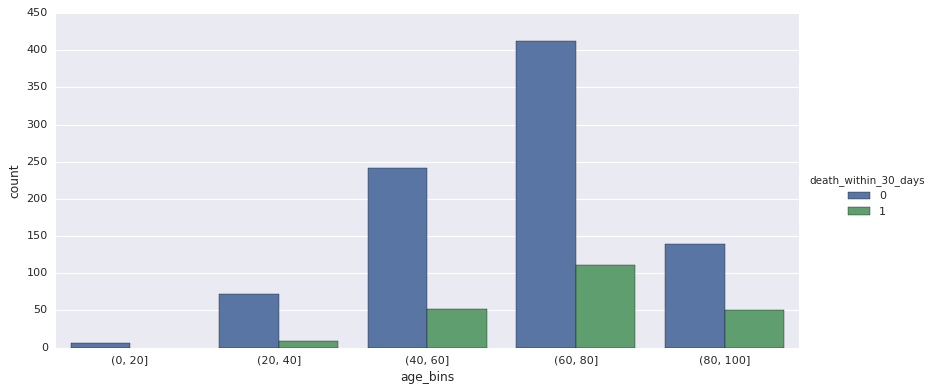

In [18]:
g = sns.factorplot("age_bins", hue="death_within_30_days",data=patient_and_admission_data, kind="count", size=5, aspect=2)

__Let's see the same data by percentage__

In [19]:
percent_death_within_30_days_by_agegroup=pd.DataFrame(death_within_30_days_by_agegroup.groupby(level=[0]).apply(lambda x: x*100 / x.sum()))
percent_death_within_30_days_by_agegroup.rename(columns={"age_bins":"death_percent"},inplace=True)
percent_death_within_30_days_by_agegroup.reset_index(inplace=True)
percent_death_within_30_days_by_agegroup

,age_bins,death_within_30_days,death_percent
0,"(0, 20]",0,100.000000
1,"(20, 40]",0,88.888889
2,"(20, 40]",1,11.111111
3,"(40, 60]",0,82.252560
4,"(40, 60]",1,17.747440
5,"(60, 80]",0,78.816794
6,"(60, 80]",1,21.183206
7,"(80, 100]",0,73.684211
8,"(80, 100]",1,26.315789


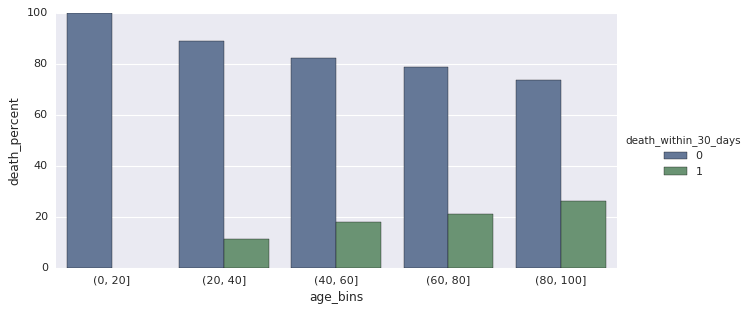

In [20]:
g = sns.factorplot(x="age_bins", y="death_percent", hue="death_within_30_days",
...                    data=percent_death_within_30_days_by_agegroup, saturation=.5,
...                    kind="bar", ci=8, aspect=2)
g.set(ylim=(0,100))

___As the age goes up, it appears that percentage of death goes up.___

** Number and Percentage of customers by Gender in the dataset **

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5acadc0ed0>], dtype=object)

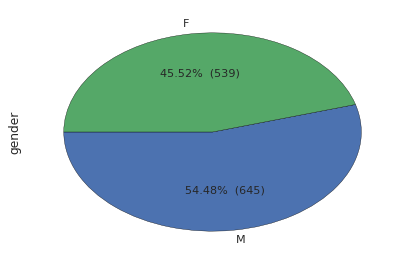

In [21]:
patient_and_admission_data.gender.value_counts().plot(kind='pie',autopct=make_autopct(patient_and_admission_data.gender.value_counts()),startangle = 180, subplots=True)

** Survival Count by Gender in the dataset **

In [22]:
death_within_30_days_by_gender = patient_and_admission_data[['gender','death_within_30_days']].groupby(['death_within_30_days','gender'])['gender'].count()

In [23]:
death_within_30_days_by_gender.describe

<bound method Series.describe of death_within_30_days  gender
0                     F         432
                      M         500
1                     F         107
                      M         145
Name: gender, dtype: int64>

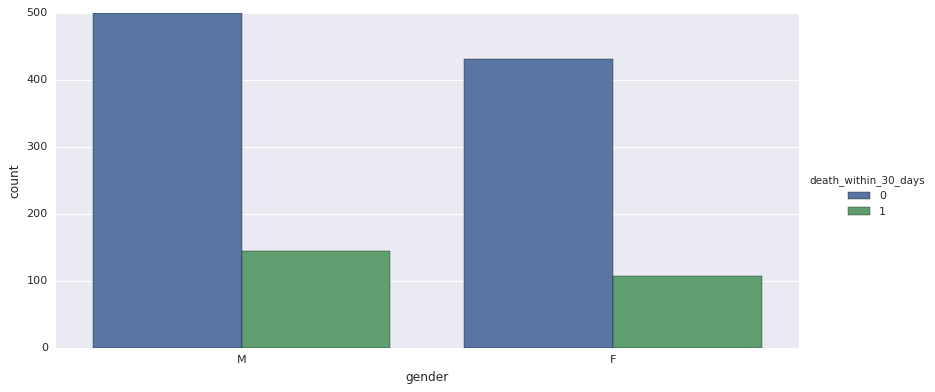

In [24]:
g = sns.factorplot("gender", hue="death_within_30_days",data=patient_and_admission_data, kind="count", size=5, aspect=2)

** Survival and Death by percentage across both genders **

**Note** - Perecentage wise, it appears that death because of Sepsis is same across both genders.

In [25]:
percent_death_within_30_days_by_gender=pd.DataFrame(death_within_30_days_by_gender.groupby(level=[1]).apply(lambda x: x*100 / x.sum()))
percent_death_within_30_days_by_gender.rename(columns={"gender": 'Percent'}, inplace=True)
percent_death_within_30_days_by_gender.reset_index(inplace=True)
percent_death_within_30_days_by_gender.sort_values(by="gender")

,death_within_30_days,gender,Percent
0,0,F,80.148423
2,1,F,19.851577
1,0,M,77.519380
3,1,M,22.480620


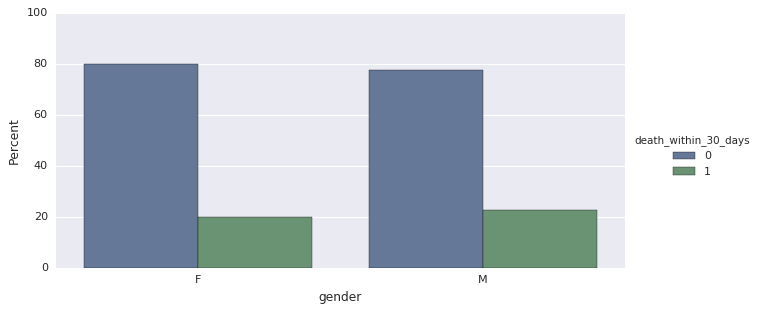

In [26]:
g = sns.factorplot(x="gender", y="Percent", hue="death_within_30_days",
...                    data=percent_death_within_30_days_by_gender, saturation=.5,
...                    kind="bar", ci=8, aspect=2)
g.set(ylim=(0,100))

**Number and Percentage of customers by Insurance in the dataset**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5acaa060d0>], dtype=object)

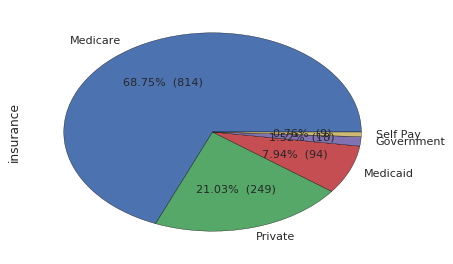

In [27]:
#patient_and_admission_data.insurance.value_counts().plot(kind='pie',autopct=make_autopct(patient_and_admission_data.insurance.value_counts()),startangle = 90, subplots=True,colormap='Pastel2')
patient_and_admission_data.insurance.value_counts().plot(kind='pie',autopct=make_autopct(patient_and_admission_data.insurance.value_counts()),subplots=True)

** Survival and Death by percentage across the insurance in the dataset**

In [28]:
death_within_30_days_by_insurance = patient_and_admission_data.groupby(['insurance','death_within_30_days'])['gender'].count()

In [29]:
death_within_30_days_by_insurance

insurance   death_within_30_days
Government  0                        14
            1                         4
Medicaid    0                        74
            1                        20
Medicare    0                       625
            1                       189
Private     0                       213
            1                        36
Self Pay    0                         6
            1                         3
Name: gender, dtype: int64

In [30]:
percent_death_within_30_days_by_insurance=pd.DataFrame(death_within_30_days_by_insurance.groupby(level=[0]).apply(lambda x: x*100 / x.sum()))
percent_death_within_30_days_by_insurance.rename(columns={'gender': 'Percent'}, inplace=True)
percent_death_within_30_days_by_insurance.reset_index(inplace=True)
percent_death_within_30_days_by_insurance

,insurance,death_within_30_days,Percent
0,Government,0,77.777778
1,Government,1,22.222222
2,Medicaid,0,78.723404
3,Medicaid,1,21.276596
4,Medicare,0,76.781327
5,Medicare,1,23.218673
6,Private,0,85.542169
7,Private,1,14.457831
8,Self Pay,0,66.666667
9,Self Pay,1,33.333333


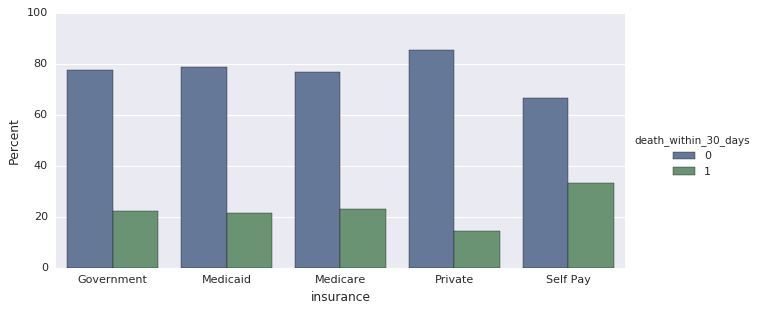

In [31]:
g = sns.factorplot(x="insurance", y="Percent", hue="death_within_30_days",
...                    data=percent_death_within_30_days_by_insurance, saturation=.5,
...                    kind="bar", ci=8, aspect=2)
g.set(ylim=(0,100))

**Number and Percentage of customers by Ethnicity in the dataset**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5aca1cb910>], dtype=object)

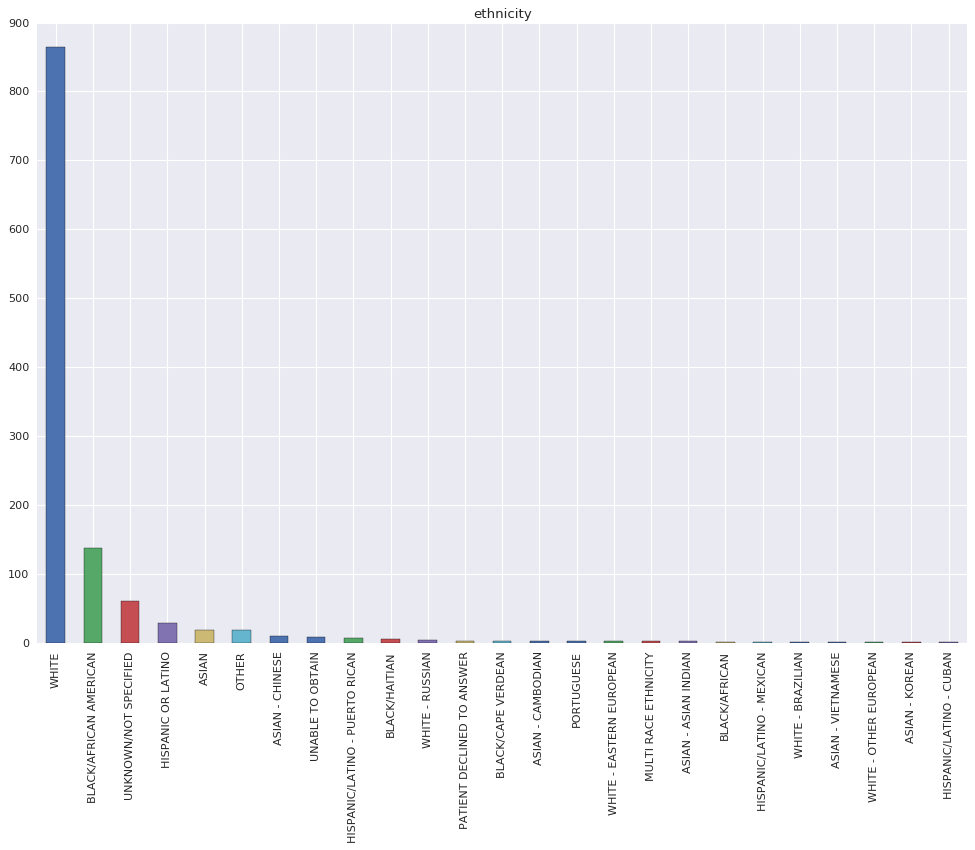

In [32]:
patient_and_admission_data.ethnicity.value_counts().plot(kind='bar',figsize=(15, 10), subplots=True)

In [33]:
death_within_30_days_by_ethnicity = patient_and_admission_data.groupby(['ethnicity','death_within_30_days'])['ethnicity'].count()
death_within_30_days_by_ethnicity

ethnicity                       death_within_30_days
ASIAN                           0                        15
                                1                         4
ASIAN - ASIAN INDIAN            0                         2
ASIAN - CAMBODIAN               0                         3
ASIAN - CHINESE                 0                         6
                                1                         4
ASIAN - KOREAN                  0                         1
ASIAN - VIETNAMESE              0                         1
BLACK/AFRICAN                   1                         1
BLACK/AFRICAN AMERICAN          0                       111
                                1                        26
BLACK/CAPE VERDEAN              0                         2
                                1                         1
BLACK/HAITIAN                   0                         5
HISPANIC OR LATINO              0                        23
                                1              

In [34]:
percent_death_within_30_days_by_ethnicity=pd.DataFrame(death_within_30_days_by_ethnicity.groupby(level=[0]).apply(lambda x: x*100 / x.sum()))
percent_death_within_30_days_by_ethnicity.rename(columns={"ethnicity": 'Percent'}, inplace=True)
percent_death_within_30_days_by_ethnicity.reset_index(inplace=True)
percent_death_within_30_days_by_ethnicity

,ethnicity,death_within_30_days,Percent
0,ASIAN,0,78.947368
1,ASIAN,1,21.052632
2,ASIAN - ASIAN INDIAN,0,100.000000
3,ASIAN - CAMBODIAN,0,100.000000
4,ASIAN - CHINESE,0,60.000000
5,ASIAN - CHINESE,1,40.000000
6,ASIAN - KOREAN,0,100.000000
7,ASIAN - VIETNAMESE,0,100.000000
8,BLACK/AFRICAN,1,100.000000
9,BLACK/AFRICAN AMERICAN,0,81.021898


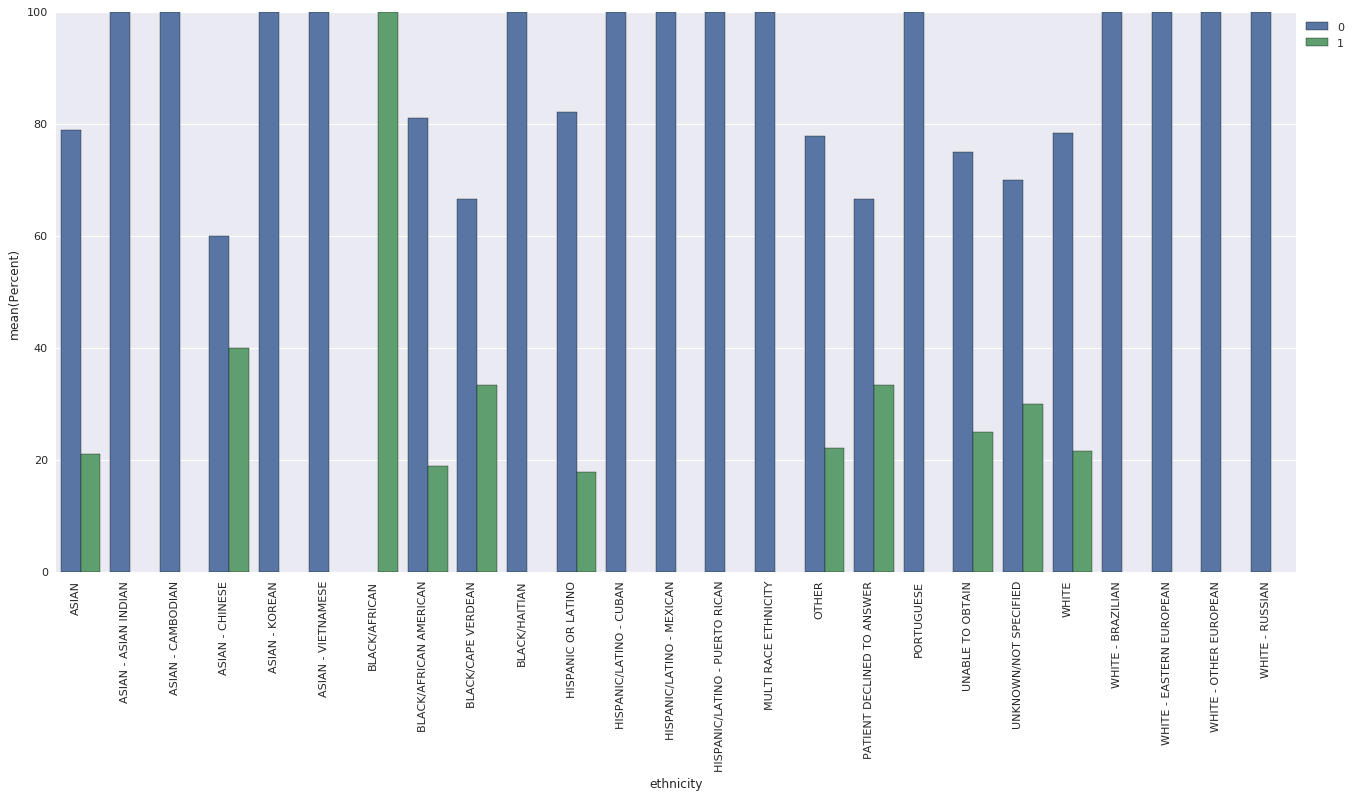

In [35]:
fig,ax = plt.subplots(figsize=(20,10))
fig.autofmt_xdate(rotation=90)
g = sns.factorplot(x="ethnicity", y="Percent", hue="death_within_30_days", data=percent_death_within_30_days_by_ethnicity, kind="bar", ax=ax)
g.set(ylim=(0,100))
ax.legend(bbox_to_anchor=(1, 1), loc=2)
plt.close(2)

## Retreive and Analyze patients vital data within 24 hours of admission

#### Retreive lab events (or vitals) for all Sepsis patients hospital admission

In [36]:
patient_hadm_ids = patient_and_admission_data.hadm_id.tolist()
lab_event_query = session.query(LabEvent).filter(LabEvent.hadm_id.in_(patient_hadm_ids))
lab_events = pd.read_sql(lab_event_query.statement, lab_event_query.session.bind)

#### Merging Patients demographic, adminission and lab data together

In [37]:
columns_to_keep = ['subject_id','hadm_id','admittime', 'admission_type','ethnicity','death_within_30_days','gender','age']
patient_lab_and_admission_data = patient_and_admission_data[columns_to_keep]
patient_lab_and_admission_data=pd.merge(lab_events,patient_lab_and_admission_data,how='left',on=['subject_id','hadm_id'])
patient_lab_and_admission_data.shape

(625316, 15)

#### Filtering out all vital information capture 24 hours after the patient was admitted

Note that we are predicting the patient's survivality within 24 hours of admission. So, we will use only the data that was captured before 24 hours of hospital admission.

In [38]:
patient_lab_and_admission_data = patient_lab_and_admission_data[(patient_lab_and_admission_data['charttime'] - patient_lab_and_admission_data['admittime'] < pd.Timedelta('1 days'))]
patient_lab_and_admission_data.reset_index(inplace=True)
patient_lab_and_admission_data.shape

(178420, 16)

#### Getting corresponding lab items for all the lab events

This is jut to get the label, fluid and category of each lab item

In [40]:
lab_event_id = patient_lab_and_admission_data['itemid'].unique().tolist()
d_labitems = Base.classes.d_labitems
d_labitems_query = session.query(d_labitems).filter(d_labitems.itemid.in_(lab_event_id))
lab_items = pd.read_sql(d_labitems_query.statement, d_labitems_query.session.bind)
lab_items.drop(['row_id','category','loinc_code'],axis=1,inplace=True)
lab_items.head()

,itemid,label,fluid
0,50800,SPECIMEN TYPE,BLOOD
1,50801,Alveolar-arterial Gradient,Blood
2,50802,Base Excess,Blood
3,50803,"Calculated Bicarbonate, Whole Blood",Blood
4,50804,Calculated Total CO2,Blood


Merge lab item with Patient's admission and vital information

In [42]:
patient_lab_and_admission_data = pd.merge(patient_lab_and_admission_data,lab_items,how='left',on=['itemid'])

In [43]:
patient_lab_and_admission_data.head()

,index,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,admittime,admission_type,ethnicity,death_within_30_days,gender,age,label,fluid
0,2,430127,652,100262,50802,2142-04-28 04:15:00,-14,-14.00,mEq/L,None,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Base Excess,Blood
1,3,430128,652,100262,50804,2142-04-28 04:15:00,16,16.00,mEq/L,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Calculated Total CO2,Blood
2,4,430129,652,100262,50818,2142-04-28 04:15:00,47,47.00,mm Hg,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pCO2,Blood
3,5,430130,652,100262,50820,2142-04-28 04:15:00,7.11,7.11,units,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pH,Blood
4,6,430131,652,100262,50821,2142-04-28 04:15:00,116,116.00,mm Hg,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pO2,Blood


__Cleaning up Patient lab and admission data to get rid of unnecessary columns__

In [44]:
patient_lab_and_admission_data.drop(['index','row_id'],axis=1, inplace=True)
patient_lab_and_admission_data.head()

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,admittime,admission_type,ethnicity,death_within_30_days,gender,age,label,fluid
0,652,100262,50802,2142-04-28 04:15:00,-14,-14.00,mEq/L,None,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Base Excess,Blood
1,652,100262,50804,2142-04-28 04:15:00,16,16.00,mEq/L,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Calculated Total CO2,Blood
2,652,100262,50818,2142-04-28 04:15:00,47,47.00,mm Hg,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pCO2,Blood
3,652,100262,50820,2142-04-28 04:15:00,7.11,7.11,units,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pH,Blood
4,652,100262,50821,2142-04-28 04:15:00,116,116.00,mm Hg,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,pO2,Blood


## Figure out which vital inormation (or lab events) to use

Note that data is being captured for 409 vital event type (or lab items type). Now, we will analyze this data to figure out which ones to use for machine learning model. We will use the ones that are being consistently captured across all the patients.

___Here is the logic - __ We have total of 1184 hospital admissions. If a lab item (or vital) data exists for at least 80% of the hospital admission (i.e. 948 hospital admissions), then we are going to use that lab item to build our machine learning model.  

Grouping the data to see how if an items exists for particular hospital admission 

In [45]:
grouped_data = pd.DataFrame(patient_lab_and_admission_data.groupby(['hadm_id','fluid','itemid'])['itemid'].count())
grouped_data.rename(columns={'itemid': 'item_count'}, inplace=True)
grouped_data.reset_index(drop=False, inplace=True)

In [46]:
grouped_data.head()

,hadm_id,fluid,itemid,item_count
0,100262,BLOOD,50800,17
1,100262,Blood,50802,16
2,100262,Blood,50804,16
3,100262,Blood,50808,3
4,100262,Blood,50810,1


In [384]:
grouped_data['item_count'].describe()

count    84853.000000
mean         2.102695
std          1.565043
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         25.000000
Name: item_count, dtype: float64

__If itemid count for a hospital admission is greater than 0, then that item is being flagged as value exists for that hospital admission.__

In [47]:
## Flaggine 1 or 0 depending upon value exists for a lab event during Admission
def to_bool(row):
    if row['item_count'] > 0:
        return 1
    else: 
        return 0
grouped_data['value_exist'] = grouped_data.apply(lambda row: to_bool(row),axis=1)
grouped_data.head()

,hadm_id,fluid,itemid,item_count,value_exist
0,100262,BLOOD,50800,17,1
1,100262,Blood,50802,16,1
2,100262,Blood,50804,16,1
3,100262,Blood,50808,3,1
4,100262,Blood,50810,1,1


__Creating a pivot table with row as hospital admission and fluid and column as item id__

In [48]:
#grouped_data.pivot(index=['hadm_id','fluid'], columns=['itemid'],values='count')
grouped_data = pd.pivot_table(grouped_data, values = 'value_exist', index=['hadm_id','fluid'], columns = 'itemid').reset_index()

In [49]:
grouped_data.head()

itemid,hadm_id,fluid,50800,50801,50802,50803,50804,50805,50806,50808,...,51511,51512,51513,51514,51515,51516,51517,51518,51519,51523
0,100262,BLOOD,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100262,Blood,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100262,Joint Fluid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100262,Urine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN
4,100328,Blood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Filtering out all the lab items (or vitals) that have data for at least 80% of hospital admissions (i.e. 948 hospital admissions)__

In [50]:
filtered_item_ids = grouped_data.sum()
filtered_item_ids = filtered_item_ids[filtered_item_ids > 947]
filtered_item_id_list = filtered_item_ids[2:].index.tolist()

In [51]:
len(filtered_item_id_list)

36

___Note: ___ Only 36 lab events have data for more than 80% admissions.

__Getting details for filtered out Lab items__

In [52]:
lab_items[lab_items['itemid'].isin(filtered_item_id_list)]

,itemid,label,fluid
12,50813,Lactate,Blood
42,50861,Alanine Aminotransferase (ALT),Blood
44,50863,Alkaline Phosphatase,Blood
48,50868,Anion Gap,Blood
54,50878,Asparate Aminotransferase (AST),Blood
57,50882,Bicarbonate,Blood
60,50885,"Bilirubin, Total",Blood
67,50893,"Calcium, Total",Blood
70,50902,Chloride,Blood
80,50912,Creatinine,Blood


__For some lab items, data has been captured but valid values haven't been entered. Value field has comment and valuenum field is null. Analyzing this data to figure out how to do manage such data.__ 

In [53]:
incomplete_lab_items = patient_lab_and_admission_data[patient_lab_and_admission_data['itemid'].isin(filtered_item_id_list)]
incomplete_lab_items = incomplete_lab_items[['itemid','value','valuenum','flag','label','fluid']]
incomplete_lab_items = incomplete_lab_items[incomplete_lab_items.valuenum.isnull()]['itemid'].value_counts()
incomplete_lab_items

51492    537
51498     25
51275      6
50882      5
50971      4
50970      3
51301      3
51279      3
51250      3
51248      3
51237      3
51277      2
51222      2
50885      2
51274      2
51249      2
50983      1
51221      1
Name: itemid, dtype: int64

__If we remove all the rows with incomplete data, trying to figure out what's the impact it will have on the remaining patient_lab_and_admission_data. Will each of these lab items will still have sufficient entries to train the machine learning model?__

In [54]:
incomplete_lab_items_list = incomplete_lab_items.index.tolist()
filtered_item_ids[filtered_item_ids.index.isin(incomplete_lab_items_list)]

itemid
50882    1175
50885     998
50970    1161
50971    1175
50983    1175
51221    1176
51222    1176
51237    1118
51248    1176
51249    1176
51250    1176
51274    1118
51275    1118
51277    1176
51279    1176
51301    1176
51492     952
51498    1033
dtype: object

__Now removing null or invalid entries from actual number of entries to understand how many rows will be left if we get rid of null/invalid rows.__

In [55]:
filtered_item_ids[filtered_item_ids.index.isin(incomplete_lab_items_list)] - incomplete_lab_items

50882    1170
50885     996
50970    1158
50971    1171
50983    1174
51221    1175
51222    1174
51237    1115
51248    1173
51249    1174
51250    1173
51274    1116
51275    1112
51277    1174
51279    1173
51301    1173
51492     415
51498    1008
dtype: object

__So except for lab item 51492 (Protein/Urine), all other lab items will still have sufficient number of rows on which we can build the machine learning model. So, we will go ahead and drop 51492 from the data.__

In [56]:
filtered_item_id_list.remove(51492)
len(filtered_item_id_list)

35

In [57]:
patient_lab_and_admission_data = patient_lab_and_admission_data[patient_lab_and_admission_data['itemid'].isin(filtered_item_id_list)]
patient_lab_and_admission_data.shape

(102898, 16)

In [58]:
patient_lab_and_admission_data.head()

,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag,admittime,admission_type,ethnicity,death_within_30_days,gender,age,label,fluid
12,652,100262,50868,2142-04-28 06:15:00,20,20.0,mEq/L,None,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Anion Gap,Blood
13,652,100262,50882,2142-04-28 06:15:00,13,13.0,mEq/L,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Bicarbonate,Blood
14,652,100262,50902,2142-04-28 06:15:00,114,114.0,mEq/L,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Chloride,Blood
17,652,100262,50912,2142-04-28 06:15:00,3.1,3.1,mg/dL,abnormal,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Creatinine,Blood
18,652,100262,50931,2142-04-28 06:15:00,83,83.0,mg/dL,None,2142-04-28 04:40:00,EMERGENCY,BLACK/AFRICAN AMERICAN,0,M,21,Glucose,Blood


__Now that we have finalized all the lab items that we will use to run machine learning models. I am going to convert the data in a format that can be further analyzed and visualized for machine learning models.__

In [59]:
patient_and_admission_data.shape

(1184, 11)

In [60]:
patient_lab_and_admission_data['hadm_id'].unique().shape

(1178,)

In [61]:
discarded_hadm_id = list(set(patient_and_admission_data['hadm_id'].unique().tolist()) - set(patient_lab_and_admission_data['hadm_id'].unique().tolist()))
discarded_hadm_id

[192691, 152550, 187308, 197907, 180378, 169179]

In [62]:
patient_and_admission_data[patient_and_admission_data['hadm_id'].isin(discarded_hadm_id)]

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_within_30_days,gender,dob,age,age_bins
74,2322,169179,2176-03-14 09:25:00,EMERGENCY,Medicaid,BLACK/AFRICAN AMERICAN,0,F,2137-09-14,38,"(20, 40]"
384,13355,187308,2157-08-01 14:25:00,URGENT,Private,WHITE,0,F,2133-05-22,24,"(20, 40]"
595,25400,197907,2142-05-06 04:33:00,EMERGENCY,Medicare,WHITE,0,F,2058-06-25,83,"(80, 100]"
745,30610,180378,2165-05-07 02:27:00,URGENT,Medicare,UNKNOWN/NOT SPECIFIED,0,F,2121-12-11,43,"(40, 60]"
1083,88662,192691,2136-05-01 13:09:00,EMERGENCY,Medicare,WHITE,0,M,2066-03-15,70,"(60, 80]"
1177,93800,152550,2153-01-01 13:40:00,EMERGENCY,Private,WHITE,0,M,2107-08-30,45,"(40, 60]"


In [63]:
x = lab_events[lab_events['itemid'].isin(filtered_item_id_list)]
#x[x['hadm_id'].isin(discarded_hadm_id)]
x[x['hadm_id'].isin([192691])]

,row_id,subject_id,hadm_id,itemid,charttime,value,valuenum,valueuom,flag


In [64]:
sepsis_festure_list = pd.pivot_table(patient_lab_and_admission_data,values='valuenum',index=['subject_id','hadm_id'],columns='label')
sepsis_festure_list

label               Alanine Aminotransferase (ALT)  Alkaline Phosphatase  \
subject_id hadm_id                                                         
21         111970                        47.000000            167.000000   
94         183686                        90.333333             68.666667   
157        107880                        13.000000            118.000000   
166        128219                              NaN                   NaN   
188        191517                       121.000000            130.000000   
353        108923                        14.000000             44.000000   
           131488                        13.000000             84.000000   
357        122609                       104.333333            140.666667   
366        134462                        68.000000             90.000000   
406        100765                        16.000000             71.000000   
           113900                        47.500000            178.500000   
           171178                        57.000000            190.000000   
433        141626                        29.000000            255.000000   
450        105452                        35.000000            110.000000   
507        148905                       300.500000             95.500000   
545        155327                        14.000000             85.000000   
558        104958                        18.500000             70.000000   
576        108911                       529.000000            131.000000   
588        170452                        10.000000             74.000000   
590        172260                        40.000000            528.000000   
618        155036                              NaN                   NaN   
652        100262                        16.500000             84.500000   
690        133648                         9.000000             79.000000   
711        114791                              NaN                   NaN   
781        163526                        31.666667            130.666667   
914        168503                        66.000000            197.000000   
940        111612                         7.666667            236.000000   
945        101713                        35.000000             88.000000   
1026       103873                         7.000000             97.000000   
1068       174792                        30.000000            109.000000   
...                                            ...                   ...   
95968      114712                        13.333333             61.333333   
96145      161427                        79.500000             91.500000   
96240      168044                        58.000000            198.500000   
96261      150731                        27.500000             89.500000   
96442      107499                        39.333333            148.000000   
96553      194204                        17.000000             65.000000   
96577      108974                       218.000000            233.000000   
96842      125486                        92.000000             59.500000   
96962      163165                              NaN                   NaN   
97039      198499                              NaN                   NaN   
97042      186645                              NaN                   NaN   
97143      122472                        21.000000            155.000000   
97353      125316                              NaN                   NaN   
97560      128116                        20.000000                   NaN   
97801      165472                              NaN                   NaN   
97923      166958                        56.000000             90.000000   
97924      100380                        26.000000             87.000000   
98220      132856                        23.000000           1093.000000   
98384      135001                        53.000000             93.500000   
98420      123804                        48.5000

In [65]:
sepsis_festure_list.shape

(1178, 35)

## Retreive and Analyze patients infection data within 24 hours of admission

Goal here is to figure out which dataset to use to build machine learning model. I considered multiple options -

1. Number of infections a patient has

2. Infection by Specimen type (e.g. Sputum infection, Blood infection etc.)

3. Organism that's present in patient's body

For this particular project, I went with option #1 and #2. There is enough data available for this and my guess is that this should provide a good prediction. 

As can be seen below - for option# 3, there is not enough data available at each organism level to use for machine learning modelling. 

##### Filtering out all the data for patients diagnosed with Sepsis

In [66]:
patient_hadm_ids = patient_and_admission_data.hadm_id.tolist()

bioevent_query = session.query(BioEvent).filter(BioEvent.hadm_id.in_(patient_hadm_ids))

patient_bio_event = pd.read_sql(bioevent_query.statement, bioevent_query.session.bind)


In [67]:
patient_bio_event.head()

,row_id,subject_id,hadm_id,chartdate,charttime,spec_itemid,spec_type_desc,org_itemid,org_name,isolate_num,ab_itemid,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation
0,8257,652,100262,2142-06-05,2142-06-05 17:12:00,70062.0,SPUTUM,80225.0,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",1.0,90013.0,TOBRAMYCIN,=>8,=>,8.0,R
1,8258,652,100262,2142-06-05,2142-06-05 17:12:00,70062.0,SPUTUM,80225.0,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",1.0,90028.0,CEFEPIME,16,=,16.0,R
2,8259,652,100262,2142-06-05,2142-06-05 17:12:00,70062.0,SPUTUM,80225.0,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",1.0,90018.0,CEFTRIAXONE,=>32,=>,32.0,R
3,8260,652,100262,2142-06-05,2142-06-05 17:12:00,70062.0,SPUTUM,80225.0,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",1.0,90029.0,MEROPENEM,1,=,1.0,S
4,8261,652,100262,2142-06-05,2142-06-05 17:12:00,70062.0,SPUTUM,80225.0,"NON-FERMENTER, NOT PSEUDOMONAS AERUGINOSA",1.0,90017.0,CEFTAZIDIME,16,=,16.0,I


#### Org_name vs. Org_itemid?

In order to figure out, if a patient has particular infection or not. Should we use Org_id or Org_name?

Based upon analysis below, it appears that org_name has 67 more data points. So, I will use org_name to figure out if patient has infection.

In [68]:
patient_bio_event.org_name.isnull().sum()

11495

In [69]:
patient_bio_event.org_itemid.isnull().sum()

11562

In [70]:
patient_bio_event[patient_bio_event.org_name.notnull() & patient_bio_event.org_itemid.isnull()].shape

(67, 16)

#### Remove columns and join with patients admissions data to get admission time

In [71]:
patient_bio_event.shape

(29281, 16)

In [72]:
patient_bio_event.columns

Index([u'row_id', u'subject_id', u'hadm_id', u'chartdate', u'charttime',
       u'spec_itemid', u'spec_type_desc', u'org_itemid', u'org_name',
       u'isolate_num', u'ab_itemid', u'ab_name', u'dilution_text',
       u'dilution_comparison', u'dilution_value', u'interpretation'],
      dtype='object')

In [73]:
columns_to_keep = ['subject_id','hadm_id','charttime','spec_type_desc','org_name']
patient_bio_event = patient_bio_event[columns_to_keep]

In [74]:
patient_bio_event = patient_bio_event.merge(patient_and_admission_data[['subject_id','hadm_id','admittime','death_within_30_days','age']],on=['subject_id','hadm_id'],how='left')

In [75]:
patient_bio_event.shape

(29281, 8)

#### Filtering out all the infections that were reported within 24 hours of Admission or 48 hours prior to admission

Picking up data 48 hours prior as many times admit time is recorded late or admission happens after all the testing.

In [76]:
patient_bio_event = patient_bio_event[(patient_bio_event['charttime'] - patient_bio_event['admittime'] < pd.Timedelta('1 days'))]
patient_bio_event = patient_bio_event[(patient_bio_event['charttime'] - patient_bio_event['admittime'] > pd.Timedelta('-2 days'))]
patient_bio_event.reset_index(inplace=True)
patient_bio_event.shape

(13284, 9)

#### Evaluate number of infections as feature (option# 1)

In [77]:
patient_bio_event.subject_id.unique().shape

(1066,)

In [78]:
patient_bio_event.hadm_id.unique().shape

(1152,)

In [79]:
num_of_infection_per_patient = patient_bio_event[patient_bio_event['org_name'].notnull()]
num_of_infection_per_patient = num_of_infection_per_patient[['subject_id','hadm_id','spec_type_desc','org_name']]
num_of_infection_per_patient.shape

(9458, 4)

In [80]:
num_of_infection_per_patient = num_of_infection_per_patient.drop_duplicates()
num_of_infection_per_patient.shape

(1449, 4)

In [81]:
num_of_infection_per_patient.head()

,subject_id,hadm_id,spec_type_desc,org_name
6,652,100262,BRONCHOALVEOLAR LAVAGE,YEAST
11,56149,100350,MRSA SCREEN,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS
24,7478,100539,BLOOD CULTURE,KLEBSIELLA PNEUMONIAE
27,7478,100539,SPUTUM,KLEBSIELLA PNEUMONIAE
42,23535,100598,STOOL,CLOSTRIDIUM DIFFICILE


In [82]:
num_of_infection_per_patient = num_of_infection_per_patient.groupby(['subject_id','hadm_id'])['spec_type_desc','org_name'].size().reset_index(name="num_of_infections")

In [83]:
num_of_infection_per_patient.head(10)

,subject_id,hadm_id,num_of_infections
0,21,111970,2
1,157,107880,3
2,166,128219,1
3,353,108923,3
4,353,131488,1
5,406,113900,2
6,406,171178,5
7,507,148905,2
8,576,108911,2
9,588,170452,6


#### *Outcome of evaluation of option 1*

We have data for num_of_infections for enough customers, so we are going to use this option as feature.

#### Evaluate specimen type available in the data as feature (option# 2)

Based upon the data below, 42 specimens types are available. Also these data are available for a majority of customers (i.e. 1152 customers).

In [84]:
patient_bio_event.spec_type_desc.unique().shape

(42,)

In [85]:
patient_bio_event.hadm_id.unique().shape

(1152,)

In [86]:
patient_bio_event['spec_type_desc'].value_counts()

BLOOD CULTURE                                               5604
URINE                                                       3320
SPUTUM                                                      1357
SWAB                                                         968
MRSA SCREEN                                                  412
STOOL                                                        318
CATHETER TIP-IV                                              260
TISSUE                                                       144
BILE                                                         118
PERITONEAL FLUID                                             112
FLUID,OTHER                                                   81
JOINT FLUID                                                   59
BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)                          58
FLUID RECEIVED IN BLOOD CULTURE BOTTLES                       49
PLEURAL FLUID                                                 46
CSF;SPINAL FLUID         

In [87]:
grouped_data = pd.DataFrame(patient_bio_event.groupby(['subject_id', 'hadm_id','spec_type_desc'])['spec_type_desc'].count())
grouped_data.rename(columns={'spec_type_desc': 'spec_type_count'}, inplace=True)
grouped_data.reset_index(drop=False,inplace=True)
grouped_data.head()

,subject_id,hadm_id,spec_type_desc,spec_type_count
0,21,111970,BLOOD CULTURE,8
1,21,111970,CATHETER TIP-IV,1
2,21,111970,STOOL,1
3,21,111970,URINE,2
4,94,183686,BLOOD CULTURE,2


Note for a patient in single admission, there are multiple entries for same specimen type. A unique entry is being created for each specimen type.

In [88]:
def to_bool(row):
    if row['spec_type_count'] > 0:
        return 1
    else: 
        return 0
    
grouped_data['value_exist'] = grouped_data.apply(lambda row: to_bool(row),axis=1)
grouped_data.head()

,subject_id,hadm_id,spec_type_desc,spec_type_count,value_exist
0,21,111970,BLOOD CULTURE,8,1
1,21,111970,CATHETER TIP-IV,1,1
2,21,111970,STOOL,1,1
3,21,111970,URINE,2,1
4,94,183686,BLOOD CULTURE,2,1


In [92]:
freq_of_specimentype_across_admissions = grouped_data.groupby(['spec_type_desc'])['value_exist'].sum()
freq_of_specimentype_across_admissions.sort_values(ascending=False)

spec_type_desc
BLOOD CULTURE                                               1080
URINE                                                        809
MRSA SCREEN                                                  362
SPUTUM                                                       267
STOOL                                                        261
SWAB                                                         116
CATHETER TIP-IV                                               94
BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)                          52
CSF;SPINAL FLUID                                              34
Influenza A/B by DFA                                          33
Rapid Respiratory Viral Screen & Culture                      30
PERITONEAL FLUID                                              28
SEROLOGY/BLOOD                                                25
TISSUE                                                        15
Immunology (CMV)                                              14
BILE      

*With specimen types, there are 5 specimens that have more than 10% data. We will use those specimens as features. Those specimens will be Blood Culture, Urine, MRSA SCREEN, SPUTUM STOOL and SWAB.*

Based upon option# 2, organizing the features by subject id and hospital admission id to use with machine learning model.

In [93]:
infection_by_specimen_type = patient_bio_event[patient_bio_event['spec_type_desc'].isin(['BLOOD CULTURE','URINE','MRSA SCREEN','SPUTUM','STOOL','SWAB'])]
infection_by_specimen_type = infection_by_specimen_type[['subject_id','hadm_id','spec_type_desc','org_name']]
infection_by_specimen_type.head()

,subject_id,hadm_id,spec_type_desc,org_name
0,652,100262,STOOL,None
1,652,100262,BLOOD CULTURE,None
2,652,100262,BLOOD CULTURE,None
3,652,100262,URINE,None
5,652,100262,SPUTUM,None


In [94]:
infection_by_specimen_type = infection_by_specimen_type.drop_duplicates()
infection_by_specimen_type.head()

,subject_id,hadm_id,spec_type_desc,org_name
0,652,100262,STOOL,None
1,652,100262,BLOOD CULTURE,None
3,652,100262,URINE,None
5,652,100262,SPUTUM,None
8,30460,100328,URINE,None


In [95]:
infection_by_specimen_type=infection_by_specimen_type[infection_by_specimen_type['org_name'].notnull()]
infection_by_specimen_type.head()

,subject_id,hadm_id,spec_type_desc,org_name
11,56149,100350,MRSA SCREEN,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS
24,7478,100539,BLOOD CULTURE,KLEBSIELLA PNEUMONIAE
27,7478,100539,SPUTUM,KLEBSIELLA PNEUMONIAE
42,23535,100598,STOOL,CLOSTRIDIUM DIFFICILE
43,23535,100598,URINE,KLEBSIELLA PNEUMONIAE


In [96]:
infection_by_specimen_type_per_admission = pd.pivot_table(infection_by_specimen_type, index=['subject_id','hadm_id'], columns='spec_type_desc', values='org_name', aggfunc=len, fill_value=0)
infection_by_specimen_type_per_admission.reset_index(inplace=True)
infection_by_specimen_type_per_admission.shape

(663, 8)

#### Evaluate Organism as feature (discussed as option# 3 above)

Let's first see if we can use organism name as feature

In [97]:
patient_bio_event['org_name'].value_counts()

ESCHERICHIA COLI                                          2604
STAPH AUREUS COAG +                                       1931
KLEBSIELLA PNEUMONIAE                                      885
PROTEUS MIRABILIS                                          843
PSEUDOMONAS AERUGINOSA                                     676
STAPHYLOCOCCUS, COAGULASE NEGATIVE                         559
ENTEROCOCCUS SP.                                           252
YEAST                                                      138
KLEBSIELLA OXYTOCA                                         129
SERRATIA MARCESCENS                                        108
STREPTOCOCCUS PNEUMONIAE                                    97
ENTEROBACTER CLOACAE                                        88
GRAM NEGATIVE ROD(S)                                        75
CITROBACTER FREUNDII COMPLEX                                70
ENTEROCOCCUS FAECIUM                                        59
POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS        

In [98]:
grouped_data = pd.DataFrame(patient_bio_event.groupby(['hadm_id','org_name'])['org_name'].count())
grouped_data.rename(columns={'org_name': 'org_name_count'}, inplace=True)
grouped_data.reset_index(drop=False,inplace=True)
grouped_data.head()

,hadm_id,org_name,org_name_count
0,100262,YEAST,1
1,100350,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1
2,100539,KLEBSIELLA PNEUMONIAE,16
3,100598,CLOSTRIDIUM DIFFICILE,1
4,100598,KLEBSIELLA PNEUMONIAE,14


Turns out there are duplicate rows for each test against hospital admission id. This is because this table also stores antibiotics information. Multiple antibiotics can be used for a single specimen type. Creating a single number for each duplicate entries.

In [99]:
def to_bool(row):
    if row['org_name_count'] > 0:
        return 1
    else: 
        return 0
grouped_data['value_exist'] = grouped_data.apply(lambda row: to_bool(row),axis=1)
grouped_data.head()

,hadm_id,org_name,org_name_count,value_exist
0,100262,YEAST,1,1
1,100350,POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS,1,1
2,100539,KLEBSIELLA PNEUMONIAE,16,1
3,100598,CLOSTRIDIUM DIFFICILE,1,1
4,100598,KLEBSIELLA PNEUMONIAE,14,1


In [101]:
freq_of_organism_across_admissions = grouped_data.groupby(['org_name'])['value_exist'].sum()
freq_of_organism_across_admissions.sort_values(ascending=False)

org_name
STAPH AUREUS COAG +                                172
ESCHERICHIA COLI                                   134
YEAST                                              118
STAPHYLOCOCCUS, COAGULASE NEGATIVE                  93
PSEUDOMONAS AERUGINOSA                              65
GRAM NEGATIVE ROD(S)                                64
ENTEROCOCCUS SP.                                    56
PROTEUS MIRABILIS                                   51
KLEBSIELLA PNEUMONIAE                               50
POSITIVE FOR METHICILLIN RESISTANT STAPH AUREUS     42
CLOSTRIDIUM DIFFICILE                               42
CORYNEBACTERIUM SPECIES (DIPHTHEROIDS)              27
PROBABLE ENTEROCOCCUS                               19
BACTEROIDES FRAGILIS GROUP                          18
2ND ISOLATE                                         16
STREPTOCOCCUS PNEUMONIAE                            15
GRAM NEGATIVE ROD #2                                15
VIRIDANS STREPTOCOCCI                               14
L

#### *Outcome of evaluation of option# 3*

*As can be seen above, not a single organism has data for more than 20% of ICU admissions. So for now, we will ignore option# 3 and will not use organism name as feature.*

In [102]:
%who_ls DataFrame

['admissions',
 'df',
 'grouped_data',
 'infection_by_specimen_type',
 'infection_by_specimen_type_per_admission',
 'lab_events',
 'lab_items',
 'num_of_infection_per_patient',
 'patient_and_admission_data',
 'patient_bio_event',
 'patient_lab_and_admission_data',
 'patients',
 'percent_death_within_30_days_by_agegroup',
 'percent_death_within_30_days_by_ethnicity',
 'percent_death_within_30_days_by_gender',
 'percent_death_within_30_days_by_insurance',
 'sepsis_festure_list',
 'x']

### Merging demographics, vital and infection data to build a single feature list

In [103]:
sepsis_festure_list.reset_index(inplace=True)
sepsis_festure_list.head()

label,subject_id,hadm_id,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",...,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Specific Gravity,Urea Nitrogen,White Blood Cells,pH
0,21,111970,47.000000,167.000000,17.0,82.000000,0.00,23.50,0.300000,7.700,...,4.40,353.500000,3.600000,17.300000,3.075000,138.5,NaN,49.500000,35.850000,NaN
1,94,183686,90.333333,68.666667,14.0,82.333333,0.85,23.25,1.033333,8.075,...,2.70,155.666667,3.100000,13.733333,3.966667,131.5,1.009,8.666667,6.066667,8.0
2,157,107880,13.000000,118.000000,17.4,25.000000,0.00,18.00,0.600000,7.940,...,4.25,247.600000,4.180000,18.960000,2.952000,137.6,1.017,12.250000,59.300000,6.5
3,166,128219,NaN,NaN,19.0,NaN,0.00,24.00,NaN,NaN,...,NaN,341.000000,3.700000,13.900000,3.980000,142.0,1.020,20.000000,16.500000,6.0
4,188,191517,121.000000,130.000000,15.0,114.000000,0.00,17.00,1.775000,7.725,...,3.30,249.000000,5.066667,16.075000,3.637500,134.0,1.021,28.250000,19.275000,6.0


In [104]:
patient_and_admission_data.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_within_30_days,gender,dob,age,age_bins
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22,63,"(60, 80]"
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22,52,"(40, 60]"
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20,74,"(60, 80]"
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,87,"(80, 100]"
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,61,"(60, 80]"


In [105]:
#infection_by_specimen_type_per_admission.reset_index(inplace=True)
#infection_by_specimen_type_per_admission.drop(['index'],axis=1,inplace=True)
infection_by_specimen_type_per_admission.columns

Index([   u'subject_id',       u'hadm_id', u'BLOOD CULTURE',   u'MRSA SCREEN',
              u'SPUTUM',         u'STOOL',          u'SWAB',         u'URINE'],
      dtype='object', name=u'spec_type_desc')

In [106]:
num_of_infection_per_patient.head()

,subject_id,hadm_id,num_of_infections
0,21,111970,2
1,157,107880,3
2,166,128219,1
3,353,108923,3
4,353,131488,1


In [107]:
print "shape of vital data for patient: "  + str(sepsis_festure_list.shape)
print "shape of demographic data: "  + str(patient_and_admission_data.shape)
print "shape of infection by specimen type data: " + str(infection_by_specimen_type_per_admission.shape)
print "shape by num of infection data: " + str(num_of_infection_per_patient.shape)

shape of vital data for patient: (1178, 37)
shape of demographic data: (1184, 11)
shape of infection by specimen type data: (663, 8)
shape by num of infection data: (705, 3)


In [108]:
Final_sepsis_feature_list = pd.merge(sepsis_festure_list,patient_and_admission_data,on=['subject_id','hadm_id'])
Final_sepsis_feature_list.shape

(1178, 46)

**Dropping feature that's not needed for Machine Learning models**

In [109]:
Final_sepsis_feature_list.drop(['admittime','dob','age_bins'], axis = 1, inplace = True)

In [110]:
Final_sepsis_feature_list.shape

(1178, 43)

In [111]:
Final_sepsis_feature_list = pd.merge(Final_sepsis_feature_list,infection_by_specimen_type_per_admission,on=['subject_id','hadm_id'],how='left')

In [112]:
Final_sepsis_feature_list.head()

,subject_id,hadm_id,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",...,ethnicity,death_within_30_days,gender,age,BLOOD CULTURE,MRSA SCREEN,SPUTUM,STOOL,SWAB,URINE
0,21,111970,47.000000,167.000000,17.0,82.000000,0.00,23.50,0.300000,7.700,...,WHITE,1,M,87,1.0,0.0,0.0,1.0,0.0,0.0
1,94,183686,90.333333,68.666667,14.0,82.333333,0.85,23.25,1.033333,8.075,...,ASIAN,0,M,74,NaN,NaN,NaN,NaN,NaN,NaN
2,157,107880,13.000000,118.000000,17.4,25.000000,0.00,18.00,0.600000,7.940,...,WHITE,0,M,80,0.0,0.0,0.0,0.0,0.0,2.0
3,166,128219,NaN,NaN,19.0,NaN,0.00,24.00,NaN,NaN,...,WHITE,1,F,300,1.0,0.0,0.0,0.0,0.0,0.0
4,188,191517,121.000000,130.000000,15.0,114.000000,0.00,17.00,1.775000,7.725,...,WHITE,0,M,51,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
Final_sepsis_feature_list = pd.merge(Final_sepsis_feature_list,num_of_infection_per_patient,on=['subject_id','hadm_id'],how='left')

In [114]:
Final_sepsis_feature_list.shape

(1178, 50)

In [115]:
Final_sepsis_feature_list.head()

,subject_id,hadm_id,Alanine Aminotransferase (ALT),Alkaline Phosphatase,Anion Gap,Asparate Aminotransferase (AST),Basophils,Bicarbonate,"Bilirubin, Total","Calcium, Total",...,death_within_30_days,gender,age,BLOOD CULTURE,MRSA SCREEN,SPUTUM,STOOL,SWAB,URINE,num_of_infections
0,21,111970,47.000000,167.000000,17.0,82.000000,0.00,23.50,0.300000,7.700,...,1,M,87,1.0,0.0,0.0,1.0,0.0,0.0,2.0
1,94,183686,90.333333,68.666667,14.0,82.333333,0.85,23.25,1.033333,8.075,...,0,M,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,157,107880,13.000000,118.000000,17.4,25.000000,0.00,18.00,0.600000,7.940,...,0,M,80,0.0,0.0,0.0,0.0,0.0,2.0,3.0
3,166,128219,NaN,NaN,19.0,NaN,0.00,24.00,NaN,NaN,...,1,F,300,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,188,191517,121.000000,130.000000,15.0,114.000000,0.00,17.00,1.775000,7.725,...,0,M,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Management of Null values in the feature set

In [116]:
Final_sepsis_feature_list.isnull().sum()

subject_id                           0
hadm_id                              0
Alanine Aminotransferase (ALT)     177
Alkaline Phosphatase               192
Anion Gap                            4
Asparate Aminotransferase (AST)    177
Basophils                           52
Bicarbonate                          4
Bilirubin, Total                   181
Calcium, Total                      17
Chloride                             3
Creatinine                           2
Eosinophils                         52
Glucose                              3
Hematocrit                           2
Hemoglobin                           2
INR(PT)                             60
Lactate                             80
Lymphocytes                         52
MCH                                  2
MCHC                                 2
MCV                                  2
Magnesium                           19
Monocytes                           52
Neutrophils                         52
PT                       

**For infection data, replacing null values with zeroes**

Assuming that if no bacteria was found (with or without test), patient didn't have infection.

In [117]:
Final_sepsis_feature_list['BLOOD CULTURE']=Final_sepsis_feature_list['BLOOD CULTURE'].fillna(0)
Final_sepsis_feature_list['MRSA SCREEN']=Final_sepsis_feature_list['MRSA SCREEN'].fillna(0)
Final_sepsis_feature_list['SPUTUM']=Final_sepsis_feature_list['SPUTUM'].fillna(0)
Final_sepsis_feature_list['STOOL']=Final_sepsis_feature_list['STOOL'].fillna(0)
Final_sepsis_feature_list['SWAB']=Final_sepsis_feature_list['SWAB'].fillna(0)
Final_sepsis_feature_list['URINE']=Final_sepsis_feature_list['URINE'].fillna(0)
Final_sepsis_feature_list['num_of_infections']=Final_sepsis_feature_list['num_of_infections'].fillna(0)


**For lab reports, replacing null values with mean of valid readings**

In [118]:
Final_sepsis_feature_list.fillna(Final_sepsis_feature_list.mean(),inplace=True)

In [119]:
Final_sepsis_feature_list.isnull().sum()

subject_id                         0
hadm_id                            0
Alanine Aminotransferase (ALT)     0
Alkaline Phosphatase               0
Anion Gap                          0
Asparate Aminotransferase (AST)    0
Basophils                          0
Bicarbonate                        0
Bilirubin, Total                   0
Calcium, Total                     0
Chloride                           0
Creatinine                         0
Eosinophils                        0
Glucose                            0
Hematocrit                         0
Hemoglobin                         0
INR(PT)                            0
Lactate                            0
Lymphocytes                        0
MCH                                0
MCHC                               0
MCV                                0
Magnesium                          0
Monocytes                          0
Neutrophils                        0
PT                                 0
PTT                                0
P

**Save the input dataframe to CSV file**

In next iPyhton notebook, I will build machine learning models using this CSV file.

In [120]:
Final_sepsis_feature_list.to_csv('Final_sepsis_feature_list.csv')

## Visualization of Infection data in the feature set

Visualization for number of infections

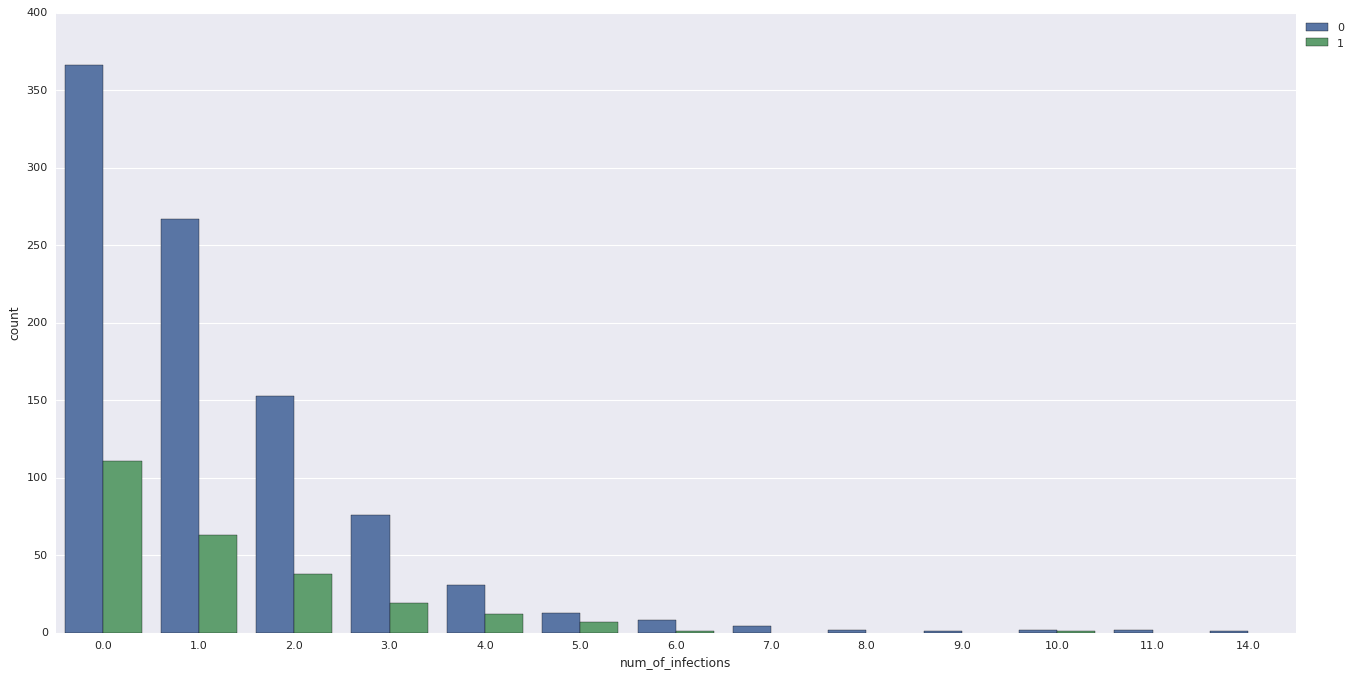

In [121]:
fig,ax = plt.subplots(figsize=(20,10))
#fig.autofmt_xdate(rotation=90)
g = sns.factorplot(x="num_of_infections", hue="death_within_30_days", data=Final_sepsis_feature_list, kind="count", ax=ax)
#g.set(ylim=(0,100))
ax.legend(bbox_to_anchor=(1, 1), loc=2)
plt.close(2)

In [122]:
percent_death_within_30_days_by_num_of_infections = Final_sepsis_feature_list.groupby(['death_within_30_days','num_of_infections'])['num_of_infections'].count()

In [124]:
percent_death_within_30_days_by_num_of_infections=pd.DataFrame(percent_death_within_30_days_by_num_of_infections.groupby(level=[1]).apply(lambda x: x*100 / x.sum()))
percent_death_within_30_days_by_num_of_infections.rename(columns={"num_of_infections": 'Percent'}, inplace=True)
percent_death_within_30_days_by_num_of_infections.reset_index(inplace=True)
percent_death_within_30_days_by_num_of_infections

,death_within_30_days,num_of_infections,Percent
0,0,0.0,76.729560
1,0,1.0,80.909091
2,0,2.0,80.104712
3,0,3.0,80.000000
4,0,4.0,72.093023
5,0,5.0,65.000000
6,0,6.0,88.888889
7,0,7.0,100.000000
8,0,8.0,100.000000
9,0,9.0,100.000000


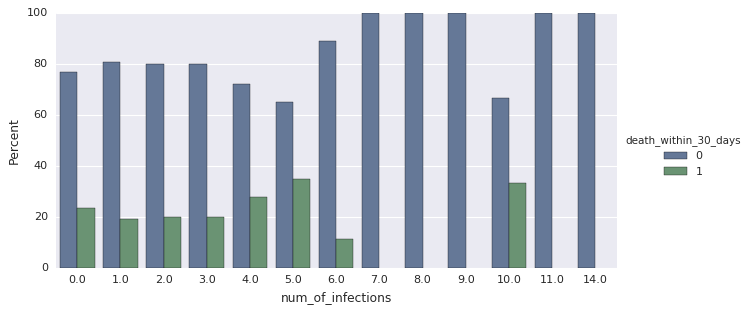

In [125]:
g = sns.factorplot(x="num_of_infections", y="Percent", hue="death_within_30_days",
...                    data=percent_death_within_30_days_by_num_of_infections, saturation=.5,
...                    kind="bar", ci=8, aspect=2)
g.set(ylim=(0,100))

#### Visualization by Specimen Type in the feature set

In [128]:
data_by_specimen_type = Final_sepsis_feature_list[['death_within_30_days','BLOOD CULTURE','MRSA SCREEN','SPUTUM','STOOL','SWAB','URINE']]

In [129]:
data_by_specimen_type = data_by_specimen_type.groupby(['death_within_30_days']).sum()

In [130]:
data_by_specimen_type.reset_index(inplace=True)
data_by_specimen_type

,death_within_30_days,BLOOD CULTURE,MRSA SCREEN,SPUTUM,STOOL,SWAB,URINE
0,0,312.0,42.0,174.0,33.0,178.0,274.0
1,1,89.0,4.0,61.0,11.0,19.0,58.0


In [131]:
data_by_specimen_type = pd.melt(data_by_specimen_type, id_vars=['death_within_30_days'], value_vars=['BLOOD CULTURE','MRSA SCREEN','SPUTUM','STOOL','SWAB','URINE'],
...         var_name='Specimen Type', value_name='Count')
data_by_specimen_type

,death_within_30_days,Specimen Type,Count
0,0,BLOOD CULTURE,312.0
1,1,BLOOD CULTURE,89.0
2,0,MRSA SCREEN,42.0
3,1,MRSA SCREEN,4.0
4,0,SPUTUM,174.0
5,1,SPUTUM,61.0
6,0,STOOL,33.0
7,1,STOOL,11.0
8,0,SWAB,178.0
9,1,SWAB,19.0


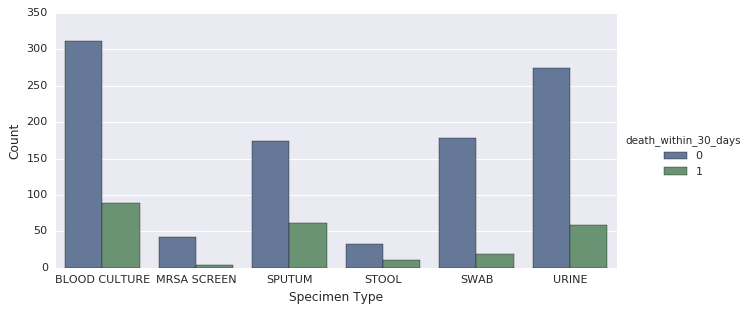

In [132]:
g = sns.factorplot(x="Specimen Type", y="Count", hue="death_within_30_days",
...                    data=data_by_specimen_type, saturation=.5,
...                    kind="bar", ci=8, aspect=2)

In [133]:
data_by_specimen_type

,death_within_30_days,Specimen Type,Count
0,0,BLOOD CULTURE,312.0
1,1,BLOOD CULTURE,89.0
2,0,MRSA SCREEN,42.0
3,1,MRSA SCREEN,4.0
4,0,SPUTUM,174.0
5,1,SPUTUM,61.0
6,0,STOOL,33.0
7,1,STOOL,11.0
8,0,SWAB,178.0
9,1,SWAB,19.0


In [134]:
data_by_specimen_type = data_by_specimen_type.groupby(['Specimen Type','death_within_30_days']).agg({'Count': 'sum'})
data_by_specimen_type['percent'] = data_by_specimen_type.groupby(level=0).apply((lambda x: x*100 / x.sum()))
data_by_specimen_type.reset_index(inplace=True)
data_by_specimen_type

,Specimen Type,death_within_30_days,Count,percent
0,BLOOD CULTURE,0,312.0,77.805486
1,BLOOD CULTURE,1,89.0,22.194514
2,MRSA SCREEN,0,42.0,91.304348
3,MRSA SCREEN,1,4.0,8.695652
4,SPUTUM,0,174.0,74.042553
5,SPUTUM,1,61.0,25.957447
6,STOOL,0,33.0,75.000000
7,STOOL,1,11.0,25.000000
8,SWAB,0,178.0,90.355330
9,SWAB,1,19.0,9.644670


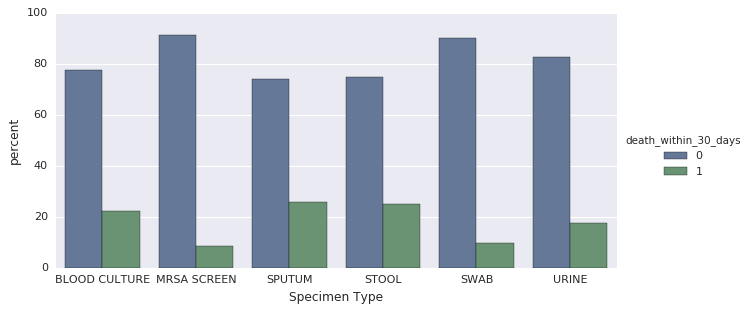

In [135]:
g = sns.factorplot(x="Specimen Type", y="percent", hue="death_within_30_days",
...                    data=data_by_specimen_type, saturation=.5,
...                    kind="bar", ci=8, aspect=2)
g.set(ylim=(0,100))